# Map Proteins with alphafold-DB structures via TED database to domains.  

In [1]:
import requests
import pandas as pd
import os
import json
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import scipy.stats as stats

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
selected_protein_ids = pd.read_csv(base_dir + os.sep + 'selected_proteins' + os.sep + 'selected_protein_ids.csv', index_col=0)


#Load Conservation data
scores_mapped = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Mapped.tsv'), index_col = 0)
params_to_plot_mapped = ['Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]', 'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]']
scores_mapped_subset = scores_mapped.loc[:,params_to_plot_mapped]

# scores_exp = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Experimental.tsv'), index_col = 0)#
# params_to_plot_exp = ['Mean(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]','Std(log2(Abundances)) 10 Sp [EXP]','1k_Mean_log2_Abundances [EXP]']
# scores_exp_subset = scores_exp.loc[:,params_to_plot_exp]



In [ ]:
# #Extract domain data for all proteins with Uniprot IDs.
# #Only need to do once - afterwards can load data structure.

# proteins_w_uniprot = selected_protein_ids.loc[~selected_protein_ids['uniprot_id'].isna(),:]


# domain_data = {}  #Comment this line out if you want to continue after an interruption.  

# failed_requests = []
# #for og_ref, proteins_w_uniprot_og_ref in proteins_w_uniprot.groupby('og_ref'):
# og_ref_already_calc = set(domain_data.keys())

# for og_ref, og_ref_ids in proteins_w_uniprot.groupby('og_ref'):

#     if og_ref in (set(proteins_w_uniprot['og_ref'])-og_ref_already_calc):
#         print(og_ref)

#         og_ref_data = {}
#         for gene_id, row in og_ref_ids.iterrows():
#             uniprot_id = row['uniprot_id']
            
            
#             #uniprot_id = 'A0A000'
#             #uniprot_id = 'Q6CI02'

#             r = requests.get('https://ted.cathdb.info/api/v1/uniprot/summary/' + uniprot_id + '?skip=0&limit=100')

#             if 'count' in set(r.json().keys()):
            
#                 n_domains = r.json()['count']

#                 r_data = r.json()['data']

#                 assert len(r_data)==n_domains, uniprot_id + ' count does not equal length of results'

#                 domain_output = []
#                 for jj in range(n_domains):
#                     r_data_domain = r_data[jj]
#                     domain_output_tuple = (r_data_domain['ted_id'],r_data_domain['cath_label'], r_data_domain['cath_assignment_method'], r_data_domain['cath_assignment_level'],r_data_domain['chopping'])
#                     domain_output.append(domain_output_tuple)

#                 og_ref_data[gene_id] = {'uniprot_id': uniprot_id, 
#                                         'domain_output': domain_output
#                 }
#             else: 
#                 print(og_ref + ' : ' + uniprot_id + 'had no count field in request')
#                 failed_requests.append((og_ref, uniprot_id))
#                 og_ref_data[gene_id] = {'uniprot_id': uniprot_id, 
#                                         'domain_output': None
#                 }
            
        
#         domain_data[og_ref] = og_ref_data


# failed_requests_fname = base_dir + os.sep + 'external_data' + os.sep + 'ted_domains' + os.sep + 'failed_requests.csv'
# with open(failed_requests_fname, 'w') as f_out: 
#     for (og_ref, uniprot_id) in failed_requests: 
#         f_out.write(og_ref + ',' + uniprot_id + '\n')



# domain_data_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data.json')
# with open(domain_data_fname, 'w') as f:
#     json.dump(domain_data, f, sort_keys=True, indent=4 )


OG1316_REF_Scer_AF-P19097-F1-model_v2
OG1316_REF_Scer_AF-P19097-F1-model_v2 : C5M7X9had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : Q6BWN1had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : Q755G1had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : A0A0J9X2G8had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : A0A0J9XEN9had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : Q6CT25had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : W0TEK0had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : C4QY10had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : C5DMJ8had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : C5E297had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : A0A1E3PXR5had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model_v2 : A0A1E3QC77had no count field in request
OG1316_REF_Scer_AF-P19097-F1-model

In [2]:
domain_data_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data.json')
with open(domain_data_fname, 'r') as f:
    domain_data = json.load(f)

In [23]:
#Tidy up domain data to separate out the fold level, choose foldseek where there are two cath assignment methods (foldseek and foldclass) and two cath assignments.  


#For each orthogroup
    #For each gene id:
    #   domain_ouput:  list including the following as a tuple for each domain
    #       ted_id
    #       cath_fold - Cath assignment to the fold level (T leve, e.g. 3.30.70)
    #       cath_superfamily - cath assignment to the superfamily level (H level, e.g. 3.30.70.3330)
    #       cath_assignment_method - foldseek or foldclass.  Foldseek is primary when there are two and foldclass has been filtered out 
    #       cath_assignment_level (T or H.  Sometimes a cath superfamily is given even though the assignment level is only T (fold).  In this case we list None here)
    #       chopping: indices of domain as given by ted (1-based numbering so first element is 1, not 0)
    #   uniprot_id

domain_data_tidy = {}

domain_data_tidy_log_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_tidy_log.txt')

with open(domain_data_tidy_log_fname,'w') as logfile: 
    for og_ref, domain_data_og_ref in domain_data.items():
        domain_data_tidy_og_ref = {}
        for gene_id, domain_data_gene in domain_data_og_ref.items():            
            
            domain_data_gene_tidy = {'uniprot_id': domain_data_gene['uniprot_id']}

            domain_output = []
            
            if domain_data_gene['domain_output'] is None: 
                domain_data_gene_tidy['domain_output'] = None
            else: 
                for (ted_id, cath_superfamily, cath_assignment_method, cath_assignment_level, chopping) in domain_data_gene['domain_output']:
                    if len(cath_superfamily.split(','))==2:   # Sometimes there were domains that got an assignment from foldseek and foldclass, in that case we only take the first one (foldseek)
                        cath_superfamily_clean = cath_superfamily.split(',')[0]
                        cath_assignment_method_clean = cath_assignment_method.split(',')[0]
                        assert cath_assignment_method_clean == 'foldseek', 'For ' + og_ref + ' ' + gene_id + 'Cath assignment method not foldseek for first listed label : ' + cath_assignment_method_clean
                        logfile.write(og_ref + ' ' + gene_id + ' double cath assignment: ' + cath_superfamily + '\n')
                    else: 
                        cath_superfamily_clean = cath_superfamily
                        cath_assignment_method_clean = cath_assignment_method
                    
                    cath_fold = None
                    if len(cath_superfamily_clean.split('.'))==3: # Sometimes there is only three levels of cath assignment - in that case we assign the label as None
                        cath_fold = cath_superfamily_clean
                        assert cath_assignment_level=='T', 'For ' + og_ref + ' ' + gene_id + ', superfamily not listed, but superfamily level assigned'
                        logfile.write(og_ref + ' ' + gene_id + ' only 3 levels listed : ' + cath_superfamily + '\n')
                        cath_superfamily_clean = None
                    elif len(cath_superfamily_clean.split('.'))==4:
                        cath_fold = '.'.join(cath_superfamily_clean.split('.')[0:3]) 
                        if cath_assignment_level=='T': #If the superfamily assignment only had fold - T level, then remove annotation for full superfamily.  
                            cath_superfamily_clean = None
                            logfile.write(og_ref + ' ' + gene_id + ' superfamily had asignment, but assignment level was only fold (T) : ' + cath_superfamily + '\n')

                    domain_output.append((ted_id, cath_fold, cath_superfamily_clean, cath_assignment_method_clean, cath_assignment_level, chopping))
                domain_data_gene_tidy['domain_output'] = domain_output
            domain_data_tidy_og_ref[gene_id] = domain_data_gene_tidy
        domain_data_tidy[og_ref] = domain_data_tidy_og_ref            



domain_data_tidy_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_tidy.json')
with open(domain_data_tidy_fname, 'w') as f:
    json.dump(domain_data_tidy, f, sort_keys=True, indent=4 )


In [2]:
domain_data_tidy_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_tidy.json')
with open(domain_data_tidy_fname, 'r') as f:
    domain_data_tidy = json.load(f)

In [4]:
#How many total uniprot ids and how many were present in TED
proteins_w_uniprot = selected_protein_ids.loc[~selected_protein_ids['uniprot_id'].isna(),:]

total_with_domains = 0

n_domains = {}
avg_domains = []


for og_ref, domain_data_og in domain_data_tidy.items(): 
    total_with_domains = total_with_domains + len(domain_data_og)
    n_domains_og_ref = []
    for gene_id, domain_data_gene in domain_data_og.items():
        if not(domain_data_gene['domain_output'] is None):
            n_domains_og_ref.append(len(domain_data_gene['domain_output']))

    avg_domains_og_ref = np.mean(n_domains_og_ref)
    
    n_domains[og_ref] = {'all_ogs': n_domains_og_ref,
                         'avg_no': avg_domains_og_ref,
                         'std': np.std(n_domains_og_ref)
    }
    avg_domains.append(avg_domains_og_ref)
print(f"{len(proteins_w_uniprot)} proteins with uniprot id, {total_with_domains} ({total_with_domains/len(proteins_w_uniprot):.0%}) were present in TED")

#Histogram of average number of domains in each orthogroup. 

9981 proteins with uniprot id, 9252 (93%) were present in TED


Text(0.5, 0, 'average number of domains per orthogroup')

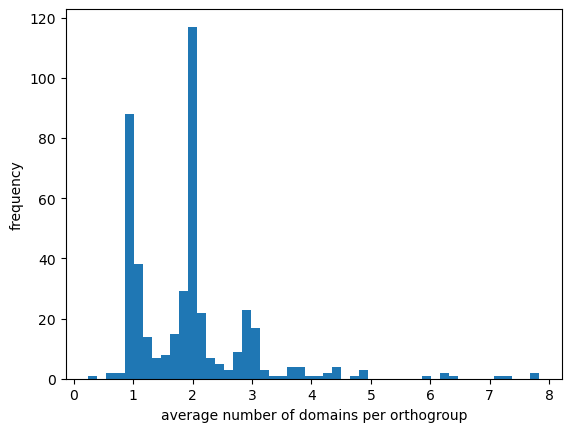

In [5]:
fig, ax = plt.subplots(1,1)

ax.hist(avg_domains,bins=50)

ax.set_ylabel('frequency')
ax.set_xlabel('average number of domains per orthogroup')

In [6]:
# Which Genes have the most domains? 
for og_ref, n_domain_data in n_domains.items():
    if n_domain_data['avg_no']>7:
        print(og_ref)

#OG1168:  ASP3-1,2,3,4, ASP1 Asparagine degradation
#OG1463:  FAS1
#OG1589: GLT1
#OG1621: ARO1

OG1168_REF_Scer_AF-P32528-F1-model_v2
OG1463_REF_Scer_AF-P07149-F1-model_v2
OG1589_REF_Scer_AF-Q12680-F1-model_v2
OG1621_REF_Scer_AF-P08566-F1-model_v2


# Analysis of Domain variability

For each orthogroup, how consistent is each domain.  Null hypothesis is that each protein will have the same number of domains and those will all be the same.  
				
Average number of domains.  Variance of number of domains
		
Take top N domains,	Check to see if the number of these top domains is more than the total.  how many proteins have one of each? 
				
Plot against conservation

In [5]:
#Make Dataframe with avg_no of domains, std and conservation keyed on og_ref


avg = []
std = []

for og_ref, n_domains_og_ref in n_domains.items():
    avg.append(n_domains_og_ref['avg_no'])
    std.append(n_domains_og_ref['std'])

n_domains_df = pd.DataFrame.from_dict({'og_ref':n_domains.keys(), 'Avg no Domains': avg, 'Std of Domain No':std})
n_domains_df.set_index('og_ref', inplace=True)

n_domains_cons = n_domains_df.merge(scores_mapped_subset, how='left', left_index=True, right_index=True)

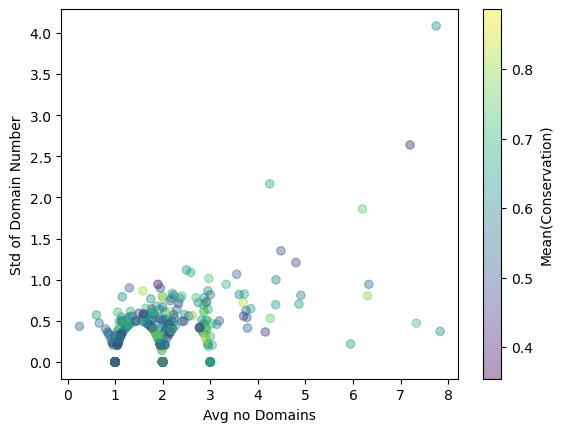

In [38]:
fig, ax = plt.subplots()

plot = ax.scatter(n_domains_cons['Avg no Domains'], n_domains_cons['Std of Domain No'], alpha=0.4, c=n_domains_cons['Mean(Conservation Rate) [ALL]'])
ax.set_xlabel('Avg no Domains')
ax.set_ylabel('Std of Domain Number')
fig.colorbar(plot, ax=ax, label='Mean(Conservation)')

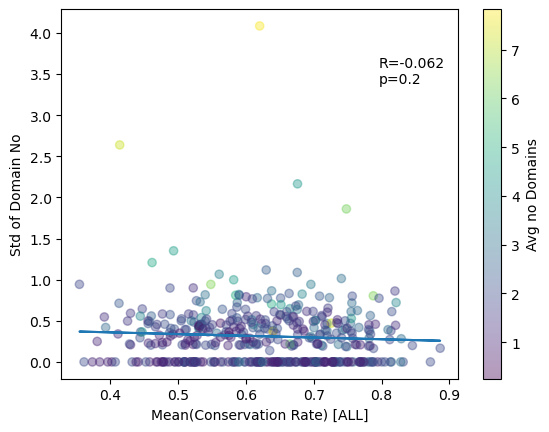

In [ ]:
fig, ax = plt.subplots()

x_label = 'Mean(Conservation Rate) [ALL]'
y_label = 'Std of Domain No'



x_data = n_domains_cons[x_label]
y_data = n_domains_cons[y_label]
c_data = n_domains_cons['Avg no Domains']

plot = ax.scatter(x_data,y_data, alpha=0.4, c=c_data)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

na_filt = x_data.notna() & y_data.notna()

x_data_filt = x_data[na_filt]
y_data_filt = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data_filt, y_data_filt)
ax.plot(list(x_data_filt), list(slope*x_data_filt+intercept))
#ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)], '--')
ax.text(0.8, 0.8, 'R={:.2}\np={:.1}'.format(r_value, p_value),transform=ax.transAxes)


fig.colorbar(plot, ax=ax, label='Avg no Domains')

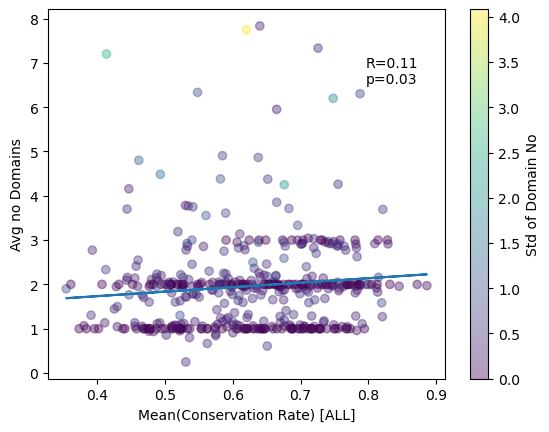

In [48]:
fig, ax = plt.subplots()

x_label = 'Mean(Conservation Rate) [ALL]'
y_label = 'Avg no Domains'

c_label = 'Std of Domain No'


x_data = n_domains_cons[x_label]
y_data = n_domains_cons[y_label]
c_data = n_domains_cons[c_label]

plot = ax.scatter(x_data,y_data, alpha=0.4, c=c_data)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

na_filt = x_data.notna() & y_data.notna()

x_data_filt = x_data[na_filt]
y_data_filt = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data_filt, y_data_filt)
ax.plot(list(x_data_filt), list(slope*x_data_filt+intercept))
#ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)], '--')
ax.text(0.8, 0.8, 'R={:.2}\np={:.1}'.format(r_value, p_value),transform=ax.transAxes)


fig.colorbar(plot, ax=ax, label=c_label)

In [ ]:
#Turn this list into a Binary Vector 
#'all domains'
#'non_conserved_domain_vector'
#'conserved_domain_vector'


{'REF_Scer_AF-P15938-F1-model_v2': [['AF-P15938-F1-model_v4_TED05',
   '1.20.120',
   '1.20.120.1080',
   'foldseek',
   'H',
   '783-911']],
 'REF_Scer_AF-P20095-F1-model_v2': [['AF-P20095-F1-model_v4_TED03',
   '1.20.120',
   '1.20.120.1080',
   'foldseek',
   'H',
   '621-778']],
 'REF_Scer_AF-P24384-F1-model_v2': [['AF-P24384-F1-model_v4_TED03',
   '2.40.50',
   '2.40.50.140',
   'foldseek',
   'H',
   '172-247'],
  ['AF-P24384-F1-model_v4_TED06',
   '1.20.120',
   '1.20.120.1080',
   'foldseek',
   'H',
   '879-1025'],
  ['AF-P24384-F1-model_v4_TED07',
   '2.30.30',
   None,
   'foldclass',
   'T',
   '1031-1110']],
 'REF_Scer_AF-P53131-F1-model_v2': [],
 'REF_Scer_AF-P40459-F1-model_v2': [],
 'REF_Scer_AF-P08004-F1-model_v2': [],
 'REF_Scer_AF-P14180-F1-model_v2': [['AF-P14180-F1-model_v4_TED01',
   '3.90.550',
   '3.90.550.10',
   'foldseek',
   'H',
   '237-531_569-592']],
 'REF_Scer_AF-P00330-F1-model_v2': [],
 'REF_Scer_AF-P00331-F1-model_v2': [],
 'REF_Scer_AF-P07246-F1-mode

In [ ]:
#Str2/Hsu1 domain swap illustration with tree and EC number

In [11]:
#og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2' # CDC19
og_ref = 'OG1390_REF_Scer_AF-P47164-F1-model_v2' #Hsu1/STR2


n_domains[og_ref]


cath_dict = {}
for gene_id, domain_data_gene_id in domain_data_tidy[og_ref].items(): 
    cath_list_gene = []
    for domain in domain_data_gene_id['domain_output']: 
        cath_list_gene.append(domain[1])
    cath_dict[gene_id] = cath_list_gene

#Counter(itertools.chain.from_iterable(cath_list))


In [14]:
' '.join(['1','2'])

'1 2'

In [20]:
#hsu1 close relatives: 

hsu1_orths = ['REF_Scer_AF-Q12198-F1-model_v2', 'lachancea_thermotolerans__OG1390__64_2695', 'torulaspora_delbrueckii__OG1390__135_4235']

str2_orths = ['REF_Scer_AF-Q04533-F1-model_v2', 'REF_Scer_AF-P47164-F1-model_v2', 'eremothecium_gossypii__OG1390__40_1574', 'kazachstania_naganishii__OG1390__49_2901', 'kluyveromyces_lactis__OG1390__50_3711', 'kluyveromyces_marxianus__OG1390__51_1596', 'lachancea_thermotolerans__OG1390__64_1533', 'torulaspora_delbrueckii__OG1390__135_1580', 'vanderwaltozyma_polyspora__OG1390__136_5100', 'zygosaccharomyces_rouxii__OG1390__342_2819']

#other orthologs :
# dict_keys(['Calb_AF-A0A1D8PD47-F1-model_v2', , ,, 
# 'Spom_AF-O74314-F1-model_v2', 'ascoidea_rubescens__OG1390__6_1513', 'candida_tropicalis__OG1390__30_2345', 
# 'cyberlindnera_jadinii__OG1390__35_1323', 'cyberlindnera_jadinii__OG1390__35_2446', 
# 'debaryomyces_hansenii__OG1390__36_2878', , 'geotrichum_candidum__OG1390__43_3823', , , ])
#'komagataella_pastoris__OG1390__52_1158',
#'lipomyces_starkeyi__OG1390__66_2809', 'ogataea_parapolymorpha__OG1390__104_3594', 'pachysolen_tannophilus__OG1390__106_3255', 'tortispora_caseinolytica__OG1390__134_1978',  'wickerhamomyces_anomalus__OG1390__139_5273', 'yarrowia_lipolytica__OG1390__144_4208'

for hsu1_orth in hsu1_orths: 
    print(hsu1_orth)
    print(cath_dict[hsu1_orth])

print('\nSTR2 Orthologs\n')

for str2_orth in str2_orths: 
    print(str2_orth)
    print(cath_dict[str2_orth])  
    

REF_Scer_AF-Q12198-F1-model_v2
['3.40.640', '3.90.1150']
lachancea_thermotolerans__OG1390__64_2695
['3.90.1150', None, '3.40.640']
torulaspora_delbrueckii__OG1390__135_4235
['3.40.640', '3.90.1150']

STR2 Orthologs

REF_Scer_AF-Q04533-F1-model_v2
['3.90.1150', '3.10.28', '3.40.640']
REF_Scer_AF-P47164-F1-model_v2
['3.90.1150', '3.30.70', '3.40.640']
eremothecium_gossypii__OG1390__40_1574
['3.30.70', '3.40.640', '3.90.1150']
kazachstania_naganishii__OG1390__49_2901
[None, '3.40.640', '3.90.1150']
kluyveromyces_lactis__OG1390__50_3711
[None, '3.40.640', '3.90.1150']
kluyveromyces_marxianus__OG1390__51_1596
['3.90.1150', '3.30.70', '3.40.640']
lachancea_thermotolerans__OG1390__64_1533
['3.10.28', '3.40.640', '3.90.1150']
torulaspora_delbrueckii__OG1390__135_1580
[None, '3.40.640', '3.90.1150']
vanderwaltozyma_polyspora__OG1390__136_5100
[None, '3.40.640', '3.90.1150']
zygosaccharomyces_rouxii__OG1390__342_2819
[None, '3.40.640', '3.90.1150']


In [9]:
domain_data_tidy[og_ref].keys()

dict_keys(['Calb_AF-A0A1D8PD47-F1-model_v2', 'REF_Scer_AF-P47164-F1-model_v2', 'REF_Scer_AF-Q04533-F1-model_v2', 'REF_Scer_AF-Q12198-F1-model_v2', 'Spom_AF-O74314-F1-model_v2', 'ascoidea_rubescens__OG1390__6_1513', 'candida_tropicalis__OG1390__30_2345', 'cyberlindnera_jadinii__OG1390__35_1323', 'cyberlindnera_jadinii__OG1390__35_2446', 'debaryomyces_hansenii__OG1390__36_2878', 'eremothecium_gossypii__OG1390__40_1574', 'geotrichum_candidum__OG1390__43_3823', 'kazachstania_naganishii__OG1390__49_2901', 'kluyveromyces_lactis__OG1390__50_3711', 'kluyveromyces_marxianus__OG1390__51_1596', 'komagataella_pastoris__OG1390__52_1158', 'lachancea_thermotolerans__OG1390__64_1533', 'lachancea_thermotolerans__OG1390__64_2695', 'lipomyces_starkeyi__OG1390__66_2809', 'ogataea_parapolymorpha__OG1390__104_3594', 'pachysolen_tannophilus__OG1390__106_3255', 'tortispora_caseinolytica__OG1390__134_1978', 'torulaspora_delbrueckii__OG1390__135_1580', 'torulaspora_delbrueckii__OG1390__135_4235', 'vanderwaltozy

In [7]:
cath_list

[[None, '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.90.1150', '3.10.28', '3.40.640'],
 ['3.40.640', '3.90.1150'],
 [None, '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.60.20', '3.40.50'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 [None, '3.40.640', '3.90.1150'],
 [None, '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.10.28', '3.40.640', '3.90.1150'],
 ['3.90.1150', None, '3.40.640'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.30.70', '3.40.640'],
 ['3.10.28', '3.40.640', '3.90.1150'],
 [None, '3.40.640', '3.90.1150'],
 ['3.40.640', '3.90.1150'],
 [None, '3.40.640', '3.90.1150'],
 ['3.30.70', '3.40.640', '3.90.1150'],
 ['3.90.1150', '3.40.640'],
 [None, '3.40.640', '3.90.115

In [9]:
#Get domain information for ref seqs

#For each orthogroup

#In structures from S. cerevisiae
#   key: gene_id
#   domain_info:  list including the following as a tuple for each domain
#       domain_ind: Index of domain for that gene
#       ted_id
#       cath_fold - Cath assignment to the fold level (T leve, e.g. 3.30.70)
#       cath_superfamily - cath assignment to the superfamily level (H level, e.g. 3.30.70.3330)
#       cath_assignment_method 
#       cath_assignment_level (T or H.  Sometimes a cath superfamily is given even though the assignment level is only T (fold).  In this case the H level may be low confidence)
#       chopping: indices of domain as given by ted (1-based numbering so first element is 1, not 0)
#   domain_vector: vector that has an indicator of domain_ind or 0 for each residue in the protein
#   og_ref_subcluster: og_ref name of subcluster.  May match the gene_id



domain_data_scer = {}

sc_data_log_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_scer_log.txt')

with open(sc_data_log_fname,'w') as logfile: 
    for og_ref, domain_data_og_ref in domain_data.items():
        for gene_id, domain_data_gene in domain_data_og_ref.items():
            og_ref_fname = base_dir + os.sep + os.path.normpath('selected_proteins/og_sequences/proteome_tm/' + og_ref + '.pep.fasta')
            if gene_id.split('_')[0]=='REF':    #only for genes from S. cerevisiae
                print(gene_id)
                domain_data_scer[gene_id] = {'og_ref_subcluster': og_ref}

                seq_records_og_ref = SeqIO.parse(og_ref_fname, "fasta")

                for record in seq_records_og_ref: 
                    if record.id.split('.')[0] == gene_id: 
                        gene_seq = record.seq

                domain_info = []
                domain_vector = np.zeros(len(gene_seq))
                for jj, (ted_id, cath_superfamily, cath_assignment_method, cath_assignment_level, chopping) in enumerate(domain_data_gene['domain_output']):
                    domain_ind = jj+1
                    if len(cath_superfamily.split(','))==2:   # Sometimes there were domains that got an assignment from foldseek and foldclass, in that case we only take the first one (foldseek)
                        cath_superfamily_clean = cath_superfamily.split(',')[0]
                        cath_assignment_method_clean = cath_assignment_method.split(',')[0]
                        assert cath_assignment_method_clean == 'foldseek', 'For ' + og_ref + ' ' + gene_id + 'Cath assignment method not foldseek for first listed label : ' + cath_assignment_method_clean
                        logfile.write(og_ref + ' ' + gene_id + ' double cath assignment: ' + cath_superfamily + '\n')
                    else: 
                        cath_superfamily_clean = cath_superfamily
                        cath_assignment_method_clean = cath_assignment_method
                    
                    cath_fold = None
                    if len(cath_superfamily_clean.split('.'))==3: # Sometimes there is only three levels of cath assignment - in that case we assign the label as None
                        cath_fold = cath_superfamily_clean
                        assert cath_assignment_level=='T', 'For ' + og_ref + ' ' + gene_id + ', superfamily not listed, but superfamily level assigned'
                        logfile.write(og_ref + ' ' + gene_id + ' only 3 levels listed : ' + cath_superfamily + '\n')
                        cath_superfamily_clean = None
                    elif len(cath_superfamily_clean.split('.'))==4:
                        cath_fold = '.'.join(cath_superfamily_clean.split('.')[0:3]) 
                        if cath_assignment_level=='T':
                            logfile.write(og_ref + ' ' + gene_id + ' superfamily had asignment, but assignment level was only fold (T) : ' + cath_superfamily + '\n')

                    domain_info.append((domain_ind, ted_id, cath_fold ,cath_superfamily_clean, cath_assignment_method_clean, cath_assignment_level, chopping))
                    
                    chopping_list = chopping.split('_')
                    for chopping_item in chopping_list: 
                        start = int(chopping_item.split('-')[0])
                        stop = int(chopping_item.split('-')[1])
                        domain_vector[start-1:stop] = domain_ind
                domain_data_scer[gene_id]['domain_info'] = domain_info
                domain_data_scer[gene_id]['domain_vector'] = domain_vector.astype(int).tolist()

    

domain_data_scer_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_scer.json')
with open(domain_data_scer_fname, 'w') as f:
    json.dump(domain_data_scer, f, sort_keys=True, indent=4 )


REF_Scer_AF-P15938-F1-model_v2
REF_Scer_AF-P20095-F1-model_v2
REF_Scer_AF-P24384-F1-model_v2
REF_Scer_AF-P53131-F1-model_v2
REF_Scer_AF-P40459-F1-model_v2
REF_Scer_AF-P08004-F1-model_v2
REF_Scer_AF-P14180-F1-model_v2
REF_Scer_AF-P00330-F1-model_v2
REF_Scer_AF-P00331-F1-model_v2
REF_Scer_AF-P07246-F1-model_v2
REF_Scer_AF-P38113-F1-model_v2
REF_Scer_AF-P40047-F1-model_v2
REF_Scer_AF-P46367-F1-model_v2
REF_Scer_AF-P54115-F1-model_v2
REF_Scer_AF-P38715-F1-model_v2
REF_Scer_AF-P49954-F1-model_v2
REF_Scer_AF-P37291-F1-model_v2
REF_Scer_AF-P37292-F1-model_v2
REF_Scer_AF-P03965-F1-model_v2
REF_Scer_AF-P07259-F1-model_v2
REF_Scer_AF-P19414-F1-model_v2
REF_Scer_AF-P39533-F1-model_v2
REF_Scer_AF-P07245-F1-model_v2
REF_Scer_AF-P09440-F1-model_v2
REF_Scer_AF-P16861-F1-model_v2
REF_Scer_AF-P16862-F1-model_v2
REF_Scer_AF-P52910-F1-model_v2
REF_Scer_AF-Q01574-F1-model_v2
REF_Scer_AF-P21954-F1-model_v2
REF_Scer_AF-P41939-F1-model_v2
REF_Scer_AF-P53982-F1-model_v2
REF_Scer_AF-P06169-F1-model_v2
REF_Scer

In [143]:
#identify S.cer coordinates for domains that are not overall conserved

#In structures from S. cerevisiae that have a non-conserved fold.  
#That is, the fold is not in the list of the top folds for that og.  
#Top fold for the OG is defined as a CATH fold present in more than 90% of the species with data in that orthogroup. 
#'None' can be a domain name - so if the domain in S.cer has a name of 'None' and 'None' is in the most common domain names it is not listed, but if 'None' is not one of the most common domain names, that domain is listed.  

#   key: gene_id
#   domain_info:  list including the following as a tuple for each domain
#       ted_id
#       cath_fold - Cath assignment to the fold level (T leve, e.g. 3.30.70)
#       cath_superfamily - cath assignment to the superfamily level (H level, e.g. 3.30.70.3330)
#       cath_assignment_method 
#       cath_assignment_level (T or H.  Sometimes a cath superfamily is given even though the assignment level is only T (fold).  In this case the H level may be low confidence)
#       chopping: indices of domain as given by ted (1-based numbering so first element is 1, not 0)
#   domain_vector_non_conserved: vector that has an indicator of 1 for each residue in a non conserved domain
#   domain_vector_conserved: vector that has an indicator of 1 for each residue in a conserved domain
#   conserved_domains: Boolean that indicates whether there are any conserved domains in the protein
#   og_ref_subcluster: og_ref name of subcluster.  May match the gene_id

pct_thresh = 0.9 

non_conserved_domains = {}

domain_data_scer_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/domain_data_scer.json')
with open(domain_data_scer_fname, 'r') as f:
    domain_data_scer = json.load(f)

for og_ref,domain_data_tidy_og_ref in domain_data_tidy.items():  
    #og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2' # CDC19
    #og_ref = 'OG1390_REF_Scer_AF-P47164-F1-model_v2' #Hsu1/STR2

    

    n_ogs = len(n_domains[og_ref]['all_ogs'])

    n_thresh = pct_thresh*n_ogs

    cath_list = []

    scer_genes = []


    for gene_id, domain_data_gene_id in domain_data_tidy_og_ref.items(): 
        if gene_id.split('_')[0]=='REF':
            scer_genes.append(gene_id)
        cath_list_gene = []
        if not(domain_data_gene_id['domain_output'] is None): 
            for domain in domain_data_gene_id['domain_output']: 
                cath_list_gene.append(domain[1])
            cath_list.append(cath_list_gene)

    domain_counter = Counter(itertools.chain.from_iterable(cath_list))

    n_domains_ceil = int(np.ceil(n_domains[og_ref]['avg_no']))

    common_domains = domain_counter.most_common(n_domains_ceil)

    #Pick common genes that have the number of genes or more as the genes in the og with data

    common_domains_all_genes = []
    none_common = False
    for (domain_name, n_genes_with_domain) in common_domains: 
        if not(domain_name is None):
            if n_genes_with_domain >= n_thresh: 
                common_domains_all_genes.append(domain_name)
                if n_genes_with_domain > n_ogs: 
                    print("{}: domain {} has more than number of genes: {}".format(og_ref, domain_name, n_genes_with_domain))
        else: 
            none_common = True
            print("{}: None is a common domain".format(og_ref))


    for scer_gene in scer_genes: 
        non_conserved_domains_gene = []
        domain_data_scer_gene = domain_data_tidy[og_ref][scer_gene]['domain_output']
        for domain_info in domain_data_scer_gene: 
            domain_name = domain_info[1]
            if domain_name is None: # If domain name is none, add domain info as long as none is not common
                if not(none_common):
                    non_conserved_domains_gene.append(domain_info)
            else: # Add domain info if domain is not in common domains
                if not(domain_name in set(common_domains_all_genes)):
                    non_conserved_domains_gene.append(domain_info)
        non_conserved_domains[scer_gene] = {'og_ref_subcluster': og_ref, 'domain_info': non_conserved_domains_gene}

non_conserved_domains_filtered = {}

for gene_id, domain_dict in non_conserved_domains.items():
    domain_list = domain_dict['domain_info']
    if len(domain_list)>0:
        non_conserved_domains_filtered[gene_id]= {'og_ref_subcluster': og_ref, 'domain_info': domain_list}

        #Make non_conserved_domain_vec

        domain_vector_orig = domain_data_scer[gene_id]['domain_vector']

        domain_vector_non_conserved = np.zeros(len(domain_vector_orig))

        for non_conserved_domain in non_conserved_domains[gene_id]['domain_info']:
            chopping = non_conserved_domain[5]
            chopping_list = chopping.split('_')
            for chopping_item in chopping_list: 
                start = int(chopping_item.split('-')[0])
                stop = int(chopping_item.split('-')[1])
                domain_vector_non_conserved[start-1:stop] = 1

        non_conserved_domains_filtered[gene_id]['domain_vector_non_conserved'] = list(domain_vector_non_conserved)

        #Make conserved_domain_vec
        domain_vector_binary = (np.array(domain_vector_orig)>0)
        domain_vector_conserved = domain_vector_binary-np.array(domain_vector_non_conserved)

        non_conserved_domains_filtered[gene_id]['domain_vector_conserved'] = list(domain_vector_conserved)

        #Flag genes that only have non_conserved domains
        non_conserved_domains_filtered[gene_id]['conserved_domains']=True
        if sum(domain_vector_conserved)==0:
            print('{}: has only non-conserved domains'.format(gene_id))
            non_conserved_domains_filtered[gene_id]['conserved_domains']=False




non_conserved_domains_fname = base_dir + os.sep + os.path.normpath('external_data/ted_domains/non_conserved_domains.json')
with open(non_conserved_domains_fname, 'w') as f:
    json.dump(non_conserved_domains_filtered, f, sort_keys=True, indent=4 )


OG1004_REF_Scer_AF-P15938-F1-model_v2: domain 3.40.50 has more than number of genes: 130
OG1004_REF_Scer_AF-P15938-F1-model_v2: None is a common domain
OG1012_REF_Scer_AF-P08004-F1-model_v2: None is a common domain
OG1032_REF_Scer_AF-P03965-F1-model_v2: domain 3.40.50 has more than number of genes: 60
OG1032_REF_Scer_AF-P03965-F1-model_v2: domain 3.30.470 has more than number of genes: 25
OG1032_REF_Scer_AF-P03965-F1-model_v2: domain 3.30.1490 has more than number of genes: 21
OG1039_REF_Scer_AF-P19414-F1-model_v2: domain 3.30.499 has more than number of genes: 76
OG1039_REF_Scer_AF-P19414-F1-model_v2: None is a common domain
OG1052_REF_Scer_AF-P07245-F1-model_v2: domain 3.40.50 has more than number of genes: 64
OG1052_REF_Scer_AF-P07245-F1-model_v2: None is a common domain
OG1054_REF_Scer_AF-P16861-F1-model_v2: domain 3.40.50 has more than number of genes: 144
OG1054_REF_Scer_AF-P16861-F1-model_v2: None is a common domain
OG1056_REF_Scer_AF-P21954-F1-model_v2: None is a common domain


In [127]:
gene_id = "REF_Scer_AF-P00424-F1-model_v2"

In [136]:
del non_conserved_domains_filtered['REF_Scer_AF-P53909-F1-model_v2']

In [142]:
len(non_conserved_domains_filtered)

108

In [ ]:
gene_id = "REF_Scer_AF-P00424-F1-model_v2"



In [131]:
domain_vector_non_conserved

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [130]:
domain_vector_conserved

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [114]:
domain_vector_orig

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [ ]:
cloluns for oliver: 

Domain info, Rossmann / Tim Barrell, for all in S. cer

In [ ]:


#For each orthogroup

    #For each structure

    #Domains present

    #Coordinate Mapping - Mapping of domain to original coordiates, msa coordinates, ref seq coordinates. = may be complicated if shen doesn't map to uniprot - maybe oliver



#Processed data
#For each orthogroup
    #Each domain
        #pct present/absent
        #Presence/absense in each protein
        #maximal coordinates? 


